In [19]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=cfe900cfa003bd4f5920cf03fe88ba95c82dfe9b6b694f4b26593129f1851e90
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


Iteration 1/10
  Local Model 1 Accuracy: 0.5
  Local Model 2 Accuracy: 0.5869565217391305
  Local Model 3 Accuracy: 0.6086956521739131
  Local Model 4 Accuracy: 0.717391304347826
  Local Model 5 Accuracy: 0.32608695652173914
  Local Model 6 Accuracy: 0.34782608695652173
  Local Model 7 Accuracy: 0.6888888888888889
  Local Model 8 Accuracy: 0.8666666666666667
  Local Model 9 Accuracy: 0.8888888888888888
  Local Model 10 Accuracy: 0.4222222222222222
Iteration 2/10
  Local Model 1 Accuracy: 0.32608695652173914
  Local Model 2 Accuracy: 0.43478260869565216
  Local Model 3 Accuracy: 0.4782608695652174
  Local Model 4 Accuracy: 0.2826086956521739
  Local Model 5 Accuracy: 0.6739130434782609
  Local Model 6 Accuracy: 0.391304347826087
  Local Model 7 Accuracy: 0.35555555555555557
  Local Model 8 Accuracy: 0.6444444444444445
  Local Model 9 Accuracy: 0.35555555555555557
  Local Model 10 Accuracy: 0.4222222222222222
Iteration 3/10
  Local Model 1 Accuracy: 0.5869565217391305
  Local Model 2 Acc

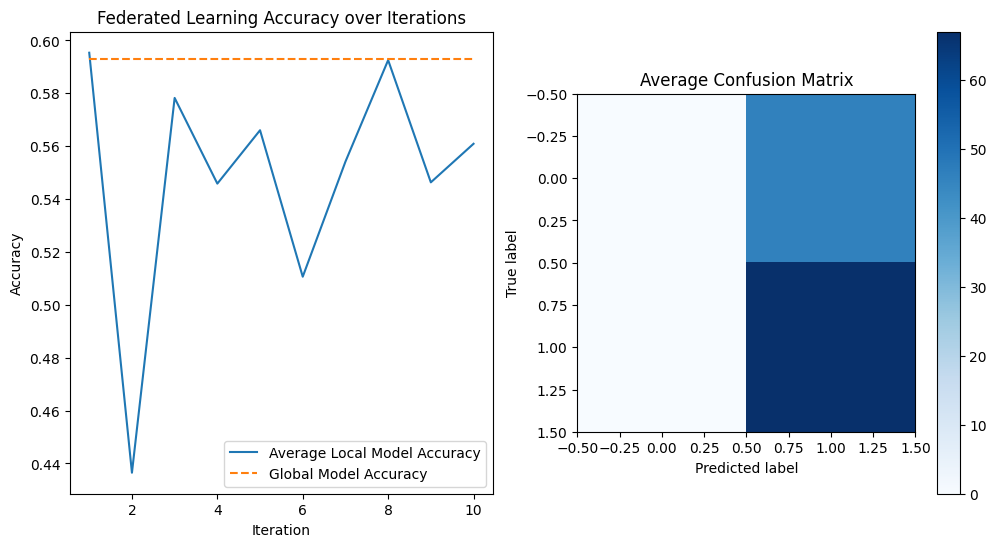

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into global and local sets
X_global, X_local, y_global, y_local = train_test_split(X, y, test_size=0.8, random_state=42)

# Define a simple model
class EfficientNetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EfficientNetModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Number of clients
num_clients = 10  # Increased number of clients

# Split local data for each client
X_locals, y_locals = np.array_split(X_local, num_clients), np.array_split(y_local, num_clients)

# Federated learning iteration
num_iterations = 10
learning_rate = 0.01

# Lists to store accuracy for each local model and global model
local_accuracies = []
global_accuracies = []

# Lists to store confusion matrices for each iteration
confusion_matrices = []

# Initialize global model
global_model = EfficientNetModel(input_size=X.shape[1], hidden_size=64, output_size=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    local_iteration_accuracies = []

    for i in range(num_clients):
        # Convert data to PyTorch tensors
        X_local_tensor = torch.tensor(X_locals[i], dtype=torch.float32)
        y_local_tensor = torch.tensor(y_locals[i], dtype=torch.long)

        # Create DataLoader for local data
        local_dataset = TensorDataset(X_local_tensor, y_local_tensor)
        local_dataloader = DataLoader(local_dataset, batch_size=32, shuffle=True)

        # Train local model on local data
        local_model = EfficientNetModel(input_size=X.shape[1], hidden_size=64, output_size=2)
        local_optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)

        for epoch in range(3):  # Number of local epochs
            for inputs, labels in local_dataloader:
                local_optimizer.zero_grad()
                outputs = local_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizer.step()

        # Evaluate local model
        X_local_eval_tensor = torch.tensor(X_locals[i], dtype=torch.float32)
        y_local_pred = torch.argmax(local_model(X_local_eval_tensor), dim=1).numpy()
        accuracy_local = accuracy_score(y_locals[i], y_local_pred)
        local_iteration_accuracies.append(accuracy_local)

        print(f"  Local Model {i + 1} Accuracy: {accuracy_local}")

        # Update global model using local model parameters
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            global_param.data += learning_rate * (local_param.data - global_param.data)

    # Calculate and store the average accuracy for the iteration
    avg_local_accuracy = sum(local_iteration_accuracies) / num_clients
    local_accuracies.append(avg_local_accuracy)

    # Evaluate the final global model
    X_global_tensor = torch.tensor(X_global, dtype=torch.float32)
    y_pred_global = torch.argmax(global_model(X_global_tensor), dim=1).numpy()
    accuracy_global = accuracy_score(y_global, y_pred_global)
    global_accuracies.append(accuracy_global)

    # Calculate and store the confusion matrix for the iteration
    confusion_matrices.append(confusion_matrix(y_global, y_pred_global))

# Plotting the accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_iterations + 1), local_accuracies, label='Average Local Model Accuracy')
plt.plot(range(1, num_iterations + 1), global_accuracies, label='Global Model Accuracy', linestyle='--')
plt.title('Federated Learning Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the confusion matrix
plt.subplot(1, 2, 2)
avg_conf_matrix = sum(confusion_matrices) // num_iterations
plt.imshow(avg_conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Average Confusion Matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


Iteration 1/10
  Local Model 1 Accuracy: 0.32608695652173914
  Local Model 2 Accuracy: 0.41304347826086957
  Local Model 3 Accuracy: 0.391304347826087
  Local Model 4 Accuracy: 0.717391304347826
  Local Model 5 Accuracy: 0.32608695652173914
  Local Model 6 Accuracy: 0.6521739130434783
  Local Model 7 Accuracy: 0.35555555555555557
  Local Model 8 Accuracy: 0.4222222222222222
  Local Model 9 Accuracy: 0.6444444444444445
  Local Model 10 Accuracy: 0.5777777777777777
Iteration 2/10
  Local Model 1 Accuracy: 0.6739130434782609
  Local Model 2 Accuracy: 0.5
  Local Model 3 Accuracy: 0.391304347826087
  Local Model 4 Accuracy: 0.9130434782608695
  Local Model 5 Accuracy: 0.6956521739130435
  Local Model 6 Accuracy: 0.6521739130434783
  Local Model 7 Accuracy: 0.6666666666666666
  Local Model 8 Accuracy: 0.9333333333333333
  Local Model 9 Accuracy: 0.35555555555555557
  Local Model 10 Accuracy: 0.37777777777777777
Iteration 3/10
  Local Model 1 Accuracy: 0.32608695652173914
  Local Model 2 Acc

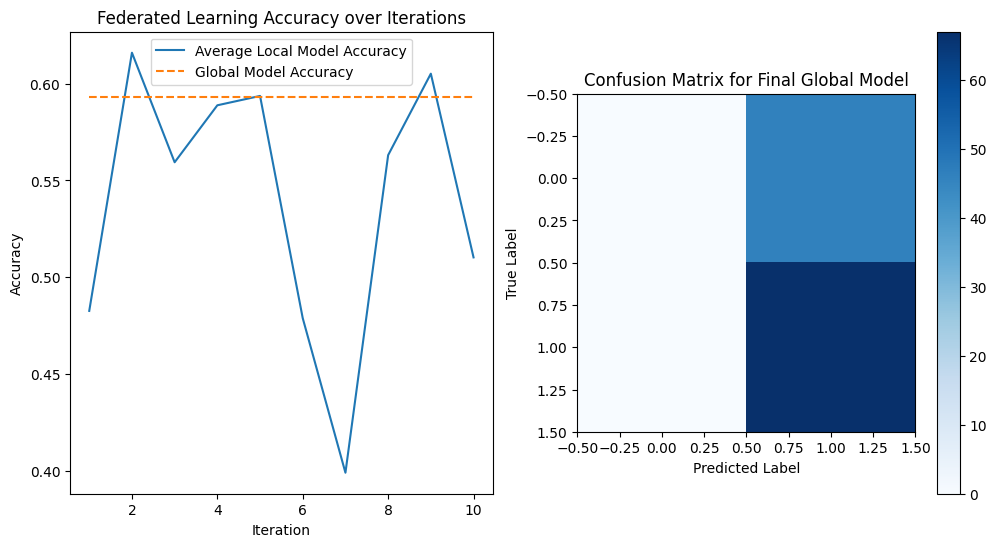


Final Global Model Metrics:
Accuracy: 0.5929203539823009
Precision: 0.5929203539823009


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, matthews_corrcoef, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into global and local sets
X_global, X_local, y_global, y_local = train_test_split(X, y, test_size=0.8, random_state=42)

# Define a simple model
class EfficientNetModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(EfficientNetModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Number of clients
num_clients = 10

# Split local data for each client
X_locals, y_locals = np.array_split(X_local, num_clients), np.array_split(y_local, num_clients)

# Federated learning iteration
num_iterations = 10
learning_rate = 0.01

# Lists to store accuracy for each local model and global model
local_accuracies = []
global_accuracies = []

# Lists to store confusion matrices for each iteration
confusion_matrices = []

# Initialize global model
global_model = EfficientNetModel(input_size=X.shape[1], hidden_size=64, output_size=2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define metrics calculation function
def calculate_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    return precision, recall, mcc, sensitivity, specificity

for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    local_iteration_accuracies = []

    for i in range(num_clients):
        # Convert data to PyTorch tensors
        X_local_tensor = torch.tensor(X_locals[i], dtype=torch.float32)
        y_local_tensor = torch.tensor(y_locals[i], dtype=torch.long)

        # Create DataLoader for local data
        local_dataset = TensorDataset(X_local_tensor, y_local_tensor)
        local_dataloader = DataLoader(local_dataset, batch_size=32, shuffle=True)

        # Train local model on local data
        local_model = EfficientNetModel(input_size=X.shape[1], hidden_size=64, output_size=2)
        local_optimizer = optim.Adam(local_model.parameters(), lr=learning_rate)

        for epoch in range(3):  # Number of local epochs
            for inputs, labels in local_dataloader:
                local_optimizer.zero_grad()
                outputs = local_model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                local_optimizer.step()

        # Evaluate local model
        X_local_eval_tensor = torch.tensor(X_locals[i], dtype=torch.float32)
        y_local_pred = torch.argmax(local_model(X_local_eval_tensor), dim=1).numpy()
        accuracy_local = accuracy_score(y_locals[i], y_local_pred)
        local_iteration_accuracies.append(accuracy_local)

        print(f"  Local Model {i + 1} Accuracy: {accuracy_local}")

        # Update global model using local model parameters
        for global_param, local_param in zip(global_model.parameters(), local_model.parameters()):
            global_param.data += learning_rate * (local_param.data - global_param.data)

    # Calculate and store the average accuracy for the iteration
    avg_local_accuracy = sum(local_iteration_accuracies) / num_clients
    local_accuracies.append(avg_local_accuracy)

    # Evaluate the final global model
    X_global_tensor = torch.tensor(X_global, dtype=torch.float32)
    y_pred_global = torch.argmax(global_model(X_global_tensor), dim=1).numpy()
    accuracy_global = accuracy_score(y_global, y_pred_global)
    global_accuracies.append(accuracy_global)

    # Calculate and store the confusion matrix for the iteration
    confusion_matrices.append(confusion_matrix(y_global, y_pred_global))

# Plotting the accuracies
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_iterations + 1), local_accuracies, label='Average Local Model Accuracy')
plt.plot(range(1, num_iterations + 1), global_accuracies, label='Global Model Accuracy', linestyle='--')
plt.title('Federated Learning Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the confusion matrix
plt.subplot(1, 2, 2)
plt.imshow(confusion_matrices[-1], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Final Global Model')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print final metrics
precision_global, recall_global, mcc_global, sensitivity_global, specificity_global = calculate_metrics(y_global, y_pred_global)
print("\nFinal Global Model Metrics:")
print(f"Accuracy: {accuracy_global}")
print(f"Precision: {precision_global}")



In [37]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Load breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Split the dataset into global and local sets
X_global, X_local, y_global, y_local = train_test_split(X, y, test_size=0.8, random_state=42)

# Define a simple logistic regression model
class LogisticRegressionModel:
    def __init__(self, input_size):
        self.weights = np.zeros(input_size)
        self.bias = 0

    def predict(self, X):
        logits = np.dot(X, self.weights) + self.bias
        return 1 / (1 + np.exp(-logits))

    def update_parameters(self, gradients, learning_rate):
        self.weights -= learning_rate * gradients[0]
        self.bias -= learning_rate * gradients[1]

# Number of clients
num_clients = 5

# Split local data for each client
X_locals, y_locals = np.array_split(X_local, num_clients), np.array_split(y_local, num_clients)

# Federated learning iteration
num_iterations = 10
learning_rate = 0.01

# Initialize global model
global_model = LogisticRegressionModel(input_size=X.shape[1])

# Federated learning loop
for iteration in range(num_iterations):
    print(f"Iteration {iteration + 1}/{num_iterations}")

    local_accuracies = []

    for i in range(num_clients):
        # Train local model on local data
        local_model = LogisticRegressionModel(input_size=X.shape[1])
        local_X, local_y = X_locals[i], y_locals[i]
        local_y_pred = local_model.predict(local_X)

        # Calculate and store local accuracy
        accuracy_local = accuracy_score(local_y, (local_y_pred >= 0.5).astype(int))
        local_accuracies.append(accuracy_local)

        # Calculate gradients and update global model parameters
        gradients_w = np.dot(local_X.T, (local_y_pred - local_y)) / len(local_y)
        gradient_b = np.sum(local_y_pred - local_y) / len(local_y)
        local_gradients = [gradients_w, gradient_b]

        global_model.update_parameters(local_gradients, learning_rate)


    # Calculate and print the average local accuracy for the iteration
    avg_local_accuracy = sum(local_accuracies) / num_clients

# Evaluate the final global model
y_global_pred = global_model.predict(X_global)
accuracy_global = accuracy_score(y_global, (y_global_pred >= 0.5).astype(int))

print(f"Final Global Model Accuracy: {accuracy_global}")


Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Final Global Model Accuracy: 0.40707964601769914


<ipython-input-37-9ebfd57e5100>:22: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-logits))
